In [22]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set()

In [23]:
def generate_sample(n_samples, bit_rate):
    # prob = (np.random.multinomial(100, [1/6.]*6, size=1)/100).flatten().tolist()

    # Define the users belong to multinomial distributed regions
    # Region code: [1: North America, 2: Europe, 3: Asia Pacific

    regions = np.random.choice(3, n_samples, p=(np.random.multinomial(n_samples, [1 / 3.] * 3,
                                                                      size=1) / n_samples).flatten().tolist()) + 1

    # Define the QoE proxied by the bit rate (bits per second)
    bit_rate_index = np.random.geometric(p=0.7, size=n_samples) - 1
    bit_rate_index[np.where(bit_rate_index > 9)] = 9

    qoe = bit_rate[bit_rate_index - 1].values

    streaming_data = qoe / 8 / 1024 / 1024 * 3600 / 1024  # GB/hour

    # Define the watching hours as the poisson distributed with the average of 28 hours per month
    # according to a Netflix study https://techcrunch.com/2017/04/10/netflix-reaches-75-of-u-s-streaming-service-viewers-but-youtube-is-catching-up/
    watching_hours = np.random.negative_binomial(n=3.2, p=0.1, size=n_samples)
    return regions, streaming_data, watching_hours

In [24]:
def consumption_region(region, data, hours):
    total_data = data * hours
    total_data_df = pd.DataFrame(data={'total_data': total_data, 'hours': hours}, index=regions)
    total_data_region = total_data_df.groupby(level=0).sum()

    return total_data_region

In [44]:
def estimate_cost(provider, total_data_region, hit_rate=0):
    cost = cost_region1 = cost_region2 = cost_region3 = 0

    total_data_region1 = float(total_data_region.loc[1].total_data)
    total_data_region2 = float(total_data_region.loc[2].total_data)
    total_data_region3 = float(total_data_region.loc[3].total_data)

    hours_region1 = float(total_data_region.loc[1].hours)
    hours_region2 = float(total_data_region.loc[2].hours)
    hours_region3 = float(total_data_region.loc[3].hours)

    data_region1_tb = total_data_region1 / 1024
    data_region2_tb = total_data_region2 / 1024
    data_region3_tb = total_data_region3 / 1024

    if provider == 'azure_premium':
        if data_region1_tb <= 10:
            cost_region1 = 0.17 * total_data_region1
        elif 10 < data_region1_tb <= 50:
            cost_region1 = 0.17 * 10 * 1024 + 0.15 * total_data_region1 - 0.15 * 10 * 1024
        elif 50 < data_region1_tb <= 150:
            cost_region1 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * total_data_region1 - 0.13 * 50 * 1024
        elif 150 < data_region1_tb <= 500:
            cost_region1 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * 100 * 1024 \
                           + 0.11 * total_data_region1 - 0.11 * 150 * 1024
        elif 500 < data_region1_tb <= 1024:
            cost_region1 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * 100 * 1024 \
                           + 0.11 * 350 * 1024 + 0.10 * total_data_region1 - 0.10 * 350 * 1024
        elif 1024 < data_region1_tb <= 5120:
            cost_region1 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * 100 * 1024 \
                           + 0.11 * 350 * 1024 + 0.10 * 524 * 1024 + 0.09 * total_data_region1 \
                           - 0.09 * 524 * 1024

        if data_region2_tb <= 10:
            cost_region2 = 0.17 * total_data_region2
        elif 10 < data_region2_tb <= 50:
            cost_region2 = 0.17 * 10 * 1024 + 0.15 * total_data_region2 - 0.15 * 10 * 1024
        elif 50 < data_region2_tb <= 150:
            cost_region2 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * total_data_region2 - 0.13 * 50 * 1024
        elif 150 < data_region2_tb <= 500:
            cost_region2 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * 100 * 1024 \
                           + 0.11 * total_data_region2 - 0.11 * 150 * 1024
        elif 500 < data_region2_tb <= 1024:
            cost_region2 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * 100 * 1024 \
                           + 0.11 * 350 * 1024 + 0.10 * total_data_region2 - 0.10 * 350 * 1024
        elif 1024 < data_region2_tb <= 5120:
            cost_region2 = 0.17 * 10 * 1024 + 0.15 * 40 * 1024 + 0.13 * 100 * 1024 \
                           + 0.11 * 350 * 1024 + 0.10 * 524 * 1024 + 0.09 * total_data_region2 \
                           - 0.09 * 524 * 1024

        if data_region3_tb <= 10:
            cost_region3 = 0.25 * total_data_region3
        elif 10 < data_region3_tb <= 50:
            cost_region3 = 0.25 * 10 * 1024 + 0.15 * total_data_region3 - 0.22 * 10 * 1024
        elif 50 < data_region3_tb <= 150:
            cost_region3 = 0.25 * 10 * 1024 + 0.22 * 40 * 1024 + 0.19 * total_data_region3 - 0.19 * 50 * 1024
        elif 150 < data_region3_tb <= 500:
            cost_region3 = 0.25 * 10 * 1024 + 0.22 * 40 * 1024 + 0.19 * 100 * 1024 \
                           + 0.16 * total_data_region3 - 0.16 * 150 * 1024
        elif 500 < data_region3_tb <= 1024:
            cost_region3 = 0.25 * 10 * 1024 + 0.22 * 40 * 1024 + 0.19 * 100 * 1024 \
                           + 0.16 * 350 * 1024 + 0.14 * total_data_region3 - 0.14 * 350 * 1024
        elif 1024 < data_region3_tb <= 5120:
            cost_region3 = 0.25 * 10 * 1024 + 0.22 * 40 * 1024 + 0.19 * 100 * 1024 \
                           + 0.16 * 350 * 1024 + 0.14 * 524 * 1024 + 0.12 * total_data_region3 \
                           - 0.12 * 524 * 1024

    if provider == 'azure':
        if data_region1_tb <= 10:
            cost_region1 = 0.087 * total_data_region1
        elif 10 < data_region1_tb <= 50:
            cost_region1 = 0.087 * 10 * 1024 + 0.08 * total_data_region1 - 0.08 * 10 * 1024
        elif 50 < data_region1_tb <= 150:
            cost_region1 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * total_data_region1 - 0.06 * 50 * 1024
        elif 150 < data_region1_tb <= 500:
            cost_region1 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 \
                           + 0.04 * total_data_region1 - 0.04 * 150 * 1024
        elif 500 < data_region1_tb <= 1024:
            cost_region1 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 \
                           + 0.04 * 350 * 1024 + 0.03 * total_data_region1 - 0.03 * 350 * 1024
        elif 1024 < data_region1_tb:
            cost_region1 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 \
                           + 0.04 * 350 * 1024 + 0.03 * 524 * 1024 + 0.025 * total_data_region1 \
                           - 0.025 * 524 * 1024

        if data_region2_tb <= 10:
            cost_region2 = 0.087 * total_data_region2
        elif 10 < data_region2_tb <= 50:
            cost_region2 = 0.087 * 10 * 1024 + 0.08 * total_data_region2 - 0.08 * 10 * 1024
        elif 50 < data_region2_tb <= 150:
            cost_region2 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * total_data_region2 - 0.06 * 50 * 1024
        elif 150 < data_region2_tb <= 500:
            cost_region2 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 \
                           + 0.04 * total_data_region2 - 0.04 * 150 * 1024
        elif 500 < data_region2_tb <= 1024:
            cost_region2 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 \
                           + 0.04 * 350 * 1024 + 0.03 * total_data_region2 - 0.03 * 350 * 1024
        elif 1024 < data_region2_tb :
            cost_region2 = 0.087 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 \
                           + 0.04 * 350 * 1024 + 0.03 * 524 * 1024 + 0.025 * total_data_region2 \
                           - 0.025 * 524 * 1024

        if data_region3_tb <= 10:
            cost_region3 = 0.138 * total_data_region3
        elif 10 < data_region3_tb <= 50:
            cost_region3 = 0.138 * 10 * 1024 + 0.13 * total_data_region3 - 0.13 * 10 * 1024
        elif 50 < data_region3_tb <= 150:
            cost_region3 = 0.138 * 10 * 1024 + 0.13 * 40 * 1024 + 0.12 * total_data_region3 - 0.12 * 50 * 1024
        elif 150 < data_region3_tb <= 500:
            cost_region3 = 0.138 * 10 * 1024 + 0.13 * 40 * 1024 + 0.12 * 100 * 1024 \
                           + 0.1 * total_data_region3 - 0.1 * 150 * 1024
        elif 500 < data_region3_tb <= 1024:
            cost_region3 = 0.138 * 10 * 1024 + 0.13 * 40 * 1024 + 0.12 * 100 * 1024 \
                           + 0.1 * 350 * 1024 + 0.08 * total_data_region3 - 0.08 * 350 * 1024
        elif 1024 < data_region3_tb :
            cost_region3 = 0.138 * 10 * 1024 + 0.13 * 40 * 1024 + 0.12 * 100 * 1024 \
                           + 0.1 * 350 * 1024 + 0.08 * 524 * 1024 + 0.07 * total_data_region3 \
                           - 0.07 * 524 * 1024



    if provider == 'aws':
        if data_region1_tb <= 10:
            cost_region1 = 0.085 * total_data_region1 + 0.0075 * hours_region1 * 3600 / 50000
        elif 10 < data_region1_tb <= 50:
            cost_region1 = 0.085 * 10 * 1024 + 0.08 * total_data_region1 - 0.08 * 10 * 1024 \
                           + 0.0075 * hours_region1 * 3600 / 50000
        elif 50 < data_region1_tb <= 150:
            cost_region1 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * total_data_region1 \
                           - 0.06 * 50 * 1024 + 0.0075 * hours_region1 * 3600 / 50000
        elif 150 < data_region1_tb <= 500:
            cost_region1 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 + 0.04 * total_data_region1 \
                           - 0.04 * 150 * 1024 + 0.0075 * hours_region1 * 3600 / 50000
        elif 500 < data_region1_tb <= 1024:
            cost_region1 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 + 0.04 * 350 * 1024 \
                           + 0.03 * total_data_region1 - 0.03 * 500 * 1024 + 0.0075 * hours_region1 * 3600 / 50000
        elif 1024 < data_region1_tb :
            cost_region1 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 + 0.04 * 350 * 1024 \
                           + 0.03 * 524 * 1024 + 0.025 * total_data_region1 - 0.025 * 1024 * 1024 \
                           + 0.0075 * hours_region1 * 3600 / 50000

        if data_region2_tb <= 10:
            cost_region2 = 0.085 * total_data_region2 + 0.009 * hours_region2 * 3600 / 50000
        elif 10 < data_region2_tb <= 50:
            cost_region2 = 0.085 * 10 * 1024 + 0.08 * total_data_region2 - 0.08 * 10 * 1024 \
                           + 0.009 * hours_region2 * 3600 / 50000
        elif 50 < data_region2_tb <= 150:
            cost_region2 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * total_data_region2 \
                           - 0.06 * 50 * 1024 + 0.009 * hours_region2 * 3600 / 50000
        elif 150 < data_region2_tb <= 500:
            cost_region2 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 + 0.04 * total_data_region2 \
                           - 0.04 * 150 * 1024 + 0.009 * hours_region2 * 3600 / 50000
        elif 500 < data_region2_tb <= 1024:
            cost_region2 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 + 0.04 * 350 * 1024 \
                           + 0.03 * total_data_region2 - 0.03 * 500 * 1024 + 0.009 * hours_region2 * 3600 / 50000
        elif 1024 < data_region2_tb:
            cost_region2 = 0.085 * 10 * 1024 + 0.08 * 40 * 1024 + 0.06 * 100 * 1024 + 0.04 * 350 * 1024 \
                           + 0.03 * 524 * 1024 + 0.025 * total_data_region2 - 0.025 * 1024 * 1024 \
                           + 0.009 * hours_region2 * 3600 / 50000

        if data_region3_tb <= 10:
            cost_region3 = 0.14 * total_data_region3 + 0.009 * hours_region3 * 3600 / 50000
        elif 10 < data_region3_tb <= 50:
            cost_region3 = 0.14 * 10 * 1024 + 0.135 * total_data_region3 - 0.135 * 10 * 1024 \
                           + 0.009 * hours_region3 * 3600 / 50000
        elif 50 < data_region3_tb <= 150:
            cost_region3 = 0.14 * 10 * 1024 + 0.135 * 40 * 1024 + 0.12 * total_data_region3 \
                           - 0.12 * 50 * 1024 + 0.009 * hours_region3 * 3600 / 50000
        elif 150 < data_region3_tb <= 500:
            cost_region3 = 0.14 * 10 * 1024 + 0.135 * 40 * 1024 + 0.12 * 100 * 1024 + 0.1 * total_data_region3 \
                           - 0.1 * 150 * 1024 + 0.009 * hours_region3 * 3600 / 50000
        elif 500 < data_region3_tb <= 1024:
            cost_region3 = 0.14 * 10 * 1024 + 0.135 * 40 * 1024 + 0.12 * 100 * 1024 + 0.1 * 350 * 1024 \
                           + 0.08 * total_data_region2 - 0.08 * 500 * 1024 + 0.009 * hours_region3 * 3600 / 50000
        elif 1024 < data_region3_tb :
            cost_region3 = 0.14 * 10 * 1024 + 0.135 * 40 * 1024 + 0.12 * 100 * 1024 + 0.1 * 350 * 1024 \
                           + 0.08 * 524 * 1024 + 0.07 * total_data_region3 - 0.07 * 1024 * 1024 \
                           + 0.009 * hours_region3 * 3600 / 50000

    if provider == 'google':

        # hit_rate = 0.5

        if data_region1_tb <= 10:
            cost_region1 = 0.08 * total_data_region1 + (1 - hit_rate) * 0.04 * total_data_region1
        elif 10 < data_region1_tb <= 150:
            cost_region1 = 0.08 * 10 * 1024 + 0.055 * total_data_region1 - 0.055 * 10 * 1024 \
                           + (1 - hit_rate) * 0.04 * total_data_region1
        elif 150 < data_region1_tb <= 1000:
            cost_region1 = 0.08 * 10 * 1024 + 0.055 * 140 * 1024 + 0.03 * total_data_region1 \
                           - 0.03 * 150 * 1024 + (1 - hit_rate) * 0.04 * total_data_region1
        elif data_region1_tb > 1000:
            cost_region1 = 0.08 * 10 * 1024 + 0.055 * 140 * 1024 + 0.03 * 850 * 1024 \
                           + 0.02 * total_data_region1 - 0.02 * 1000 * 1024 + \
                           (1 - hit_rate) * 0.04 * total_data_region1

        if data_region2_tb <= 10:
            cost_region2 = 0.08 * total_data_region2 + (1 - hit_rate) * 0.05 * total_data_region2
        elif 10 < data_region2_tb <= 150:
            cost_region2 = 0.08 * 10 * 1024 + 0.055 * total_data_region2 - 0.055 * 10 * 1024 \
                           + (1 - hit_rate) * 0.05 * total_data_region2
        elif 150 < data_region2_tb <= 1000:
            cost_region2 = 0.08 * 10 * 1024 + 0.055 * 140 * 1024 + 0.03 * total_data_region2 \
                           - 0.03 * 150 * 1024 + (1 - hit_rate) * 0.05 * total_data_region2
        elif data_region2_tb > 1000:
            cost_region2 = 0.08 * 10 * 1024 + 0.055 * 140 * 1024 + 0.03 * 850 * 1024 \
                           + 0.02 * total_data_region2 - 0.02 * 1000 * 1024 + \
                           (1 - hit_rate) * 0.05 * total_data_region2

        if data_region3_tb <= 10:
            cost_region3 = 0.09 * total_data_region3 + (1 - hit_rate) * 0.05 * total_data_region3
        elif 10 < data_region3_tb <= 150:
            cost_region3 = 0.09 * 10 * 1024 + 0.06 * total_data_region3 - 0.06 * 10 * 1024 \
                           + (1 - hit_rate) * 0.06 * total_data_region3
        elif 150 < data_region3_tb <= 1000:
            cost_region3 = 0.09 * 10 * 1024 + 0.06 * 140 * 1024 + 0.05 * total_data_region3 \
                           - 0.05 * 150 * 1024 + (1 - hit_rate) * 0.06 * total_data_region3
        elif data_region3_tb > 1000:
            cost_region3 = 0.09 * 10 * 1024 + 0.06 * 140 * 1024 + 0.05 * 850 * 1024 \
                           + 0.04 * total_data_region3 - 0.04 * 1000 * 1024 + \
                           (1 - hit_rate) * 0.06 * total_data_region3

    cost = cost_region1 + cost_region2 + cost_region3
    return cost

In [45]:
n_samples = [1000, 10000, 100000, 1000000, 10000000]  # size of sample
n_experiments = 10  # number of experiments
hit_rate_range = [0, 0.9, 1] # Cache of hit rate
total_cost = [] 

bit_rate = pd.Series({'9': 313769, '8': 722907, '7': 1292014, '6': 1917529, '5': 2925460,
                          '4': 4023268, '3': 5477193, '2': 8769548, '1': 11365148})

In [46]:
for p in ['aws', 'azure', 'google']:
    for sample in n_samples:
        for i in range(n_experiments):
            for hit_rate in hit_rate_range:
                regions, streaming_data, watching_hours = generate_sample(n_samples=sample, bit_rate=bit_rate)
                total_data_region = consumption_region(region=regions, data=streaming_data, hours=watching_hours)
                total_cost.append([p, sample, hit_rate, 
                                   estimate_cost(provider=p, total_data_region=total_data_region, hit_rate=hit_rate)])

In [47]:
total_cost_df = pd.DataFrame(total_cost, columns=['provider', 'samples', 'hit_rate', 'cost'])
total_cost_df.head()

,provider,samples,hit_rate,cost
0,aws,1000,0.0,3670.833089
1,aws,1000,0.9,3851.800141
2,aws,1000,1.0,4107.567442
3,aws,1000,0.0,4042.997993
4,aws,1000,0.9,4388.686389


In [48]:
total_cost_df[total_cost_df['provider']=='google'].head(100)

,provider,samples,hit_rate,cost
300,google,1000,0.0,5.225232e+03
301,google,1000,0.9,3.344027e+03
302,google,1000,1.0,3.104735e+03
303,google,1000,0.0,5.239487e+03
304,google,1000,0.9,3.617413e+03
305,google,1000,1.0,3.036690e+03
306,google,1000,0.0,5.183910e+03
307,google,1000,0.9,3.206807e+03
308,google,1000,1.0,2.909905e+03
309,google,1000,0.0,4.906605e+03


In [49]:
total_cost_df.columns

Index(['provider', 'samples', 'hit_rate', 'cost'], dtype='object')

In [50]:
total_cost_df.to_csv("total_cost.csv")

In [51]:
total_cost_df.rename(columns = {"hit_rate": "Google: $\eta$"})

,provider,samples,Google: $\eta$,cost
0,aws,1000,0.0,3.670833e+03
1,aws,1000,0.9,3.851800e+03
2,aws,1000,1.0,4.107567e+03
3,aws,1000,0.0,4.042998e+03
4,aws,1000,0.9,4.388686e+03
5,aws,1000,1.0,4.182572e+03
6,aws,1000,0.0,4.256960e+03
7,aws,1000,0.9,4.175536e+03
8,aws,1000,1.0,4.479245e+03
9,aws,1000,0.0,3.874340e+03


In [52]:
total_cost_df.loc[total_cost_df['provider']=='aws', 'provider']='Amazon CloudFront'
total_cost_df.loc[total_cost_df['provider']=='azure', 'provider']='Azure CDN'
total_cost_df.loc[total_cost_df['provider']=='google', 'provider']='Google CDN'
total_cost_df.head()

,provider,samples,hit_rate,cost
0,Amazon CloudFront,1000,0.0,3670.833089
1,Amazon CloudFront,1000,0.9,3851.800141
2,Amazon CloudFront,1000,1.0,4107.567442
3,Amazon CloudFront,1000,0.0,4042.997993
4,Amazon CloudFront,1000,0.9,4388.686389


In [53]:
total_cost_df.loc[(total_cost_df['provider']=='Google CDN') & (total_cost_df['hit_rate']==0.9), 'provider']='Google CDN ($\eta=0.9$)'


In [54]:
total_cost_df.loc[(total_cost_df['provider']=='Google CDN') & (total_cost_df['hit_rate']==0), 'provider']='Google CDN ($\eta=0$)'

In [55]:
total_cost_df.loc[(total_cost_df['provider']=='Google CDN') & (total_cost_df['hit_rate']==1), 'provider']='Google CDN ($\eta=1$)'

In [146]:
t = total_cost_df.groupby(['provider', 'samples'], as_index=False).mean()
type(t.samples.values)

numpy.ndarray

In [250]:
total_cost_df.loc[total_cost_df['provider']=='google' & total_cost_df['hit_rate']==0.9, 'provider']='Google CDN ($\eta$=0.9)'

TypeError: cannot compare a dtyped [float64] array with a scalar of type [bool]

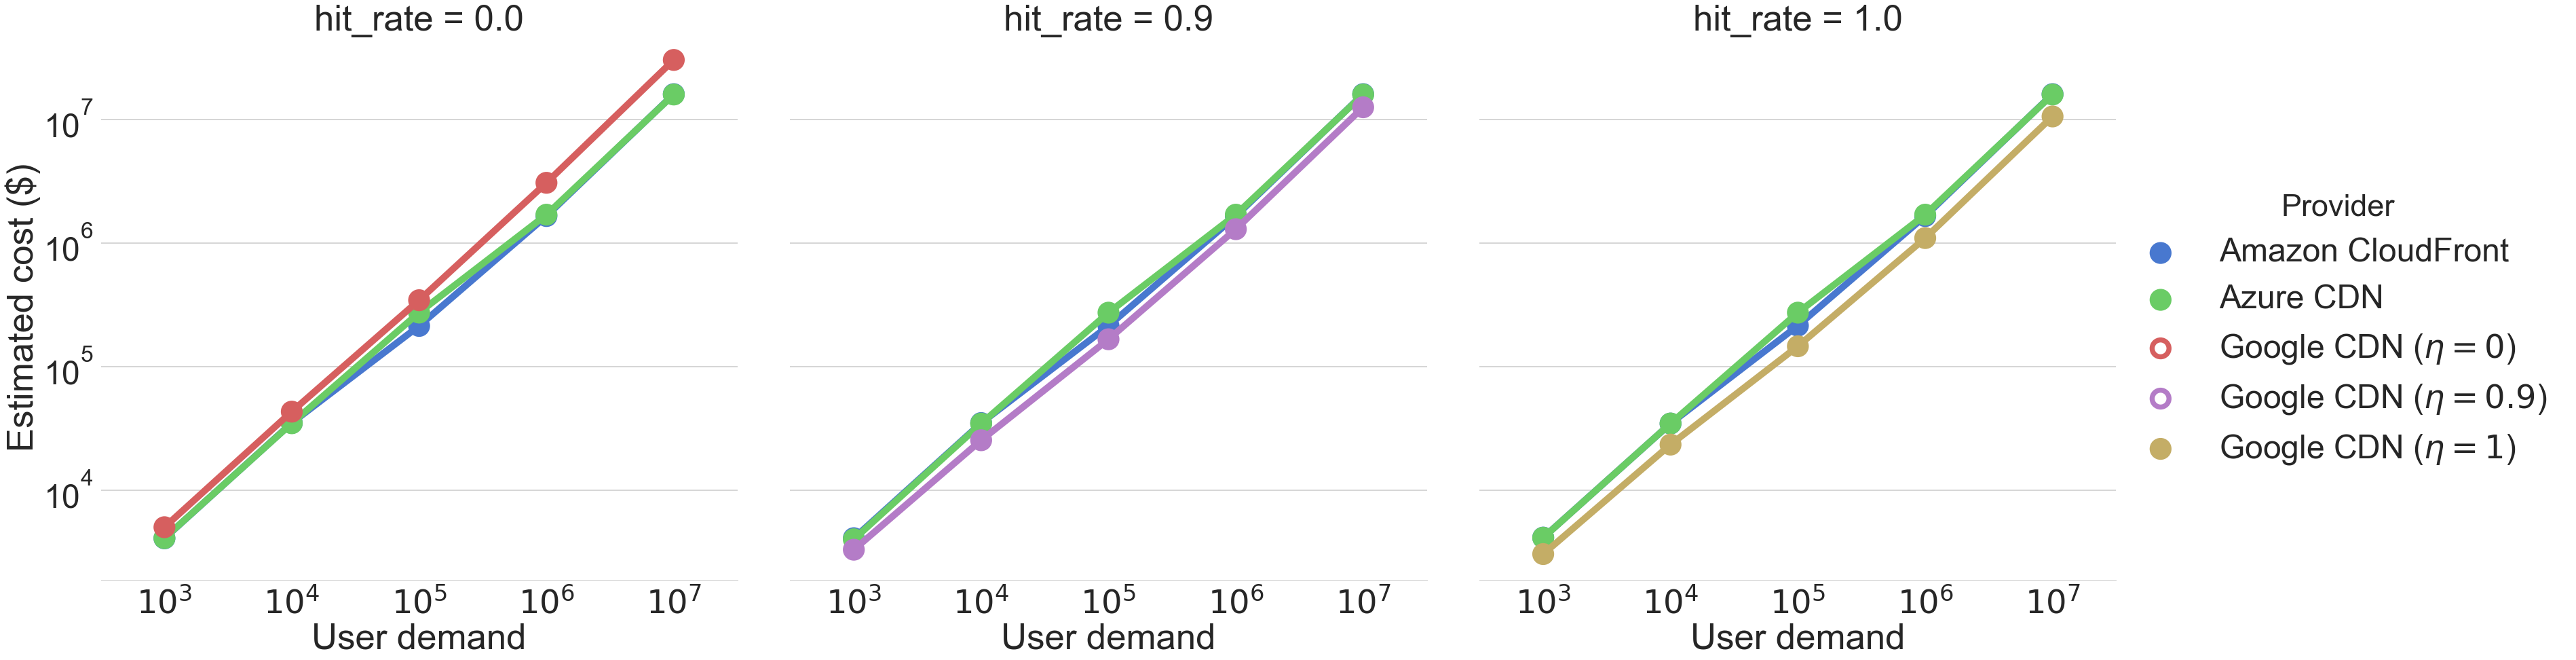

In [56]:
sns.set(style="whitegrid")
#fig, ax = plt.subplots()
#ax.set(xscale="log", yscale="log")
#sns.set_context("poster")
sns.set_context("poster", font_scale=3, rc={"lines.linewidth": 5.5})
g = sns.factorplot(x="samples", y="cost", hue="provider", data=total_cost_df, col="hit_rate", kind="point", palette="muted", ci=95,
                  n_boot=1000, size=15, aspect=1, sharex=True)

g.despine(left=True)
g.set_ylabels("Estimated cost ($)")
g.set_xlabels("User demand")
g.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'] )
g.set(yscale="log")
g._legend.set_title('Provider')
#g._legend.set_label(['Amazon CloudFront', 'Azure CDN', 'Google Cloud CDN'])
#plt.show()

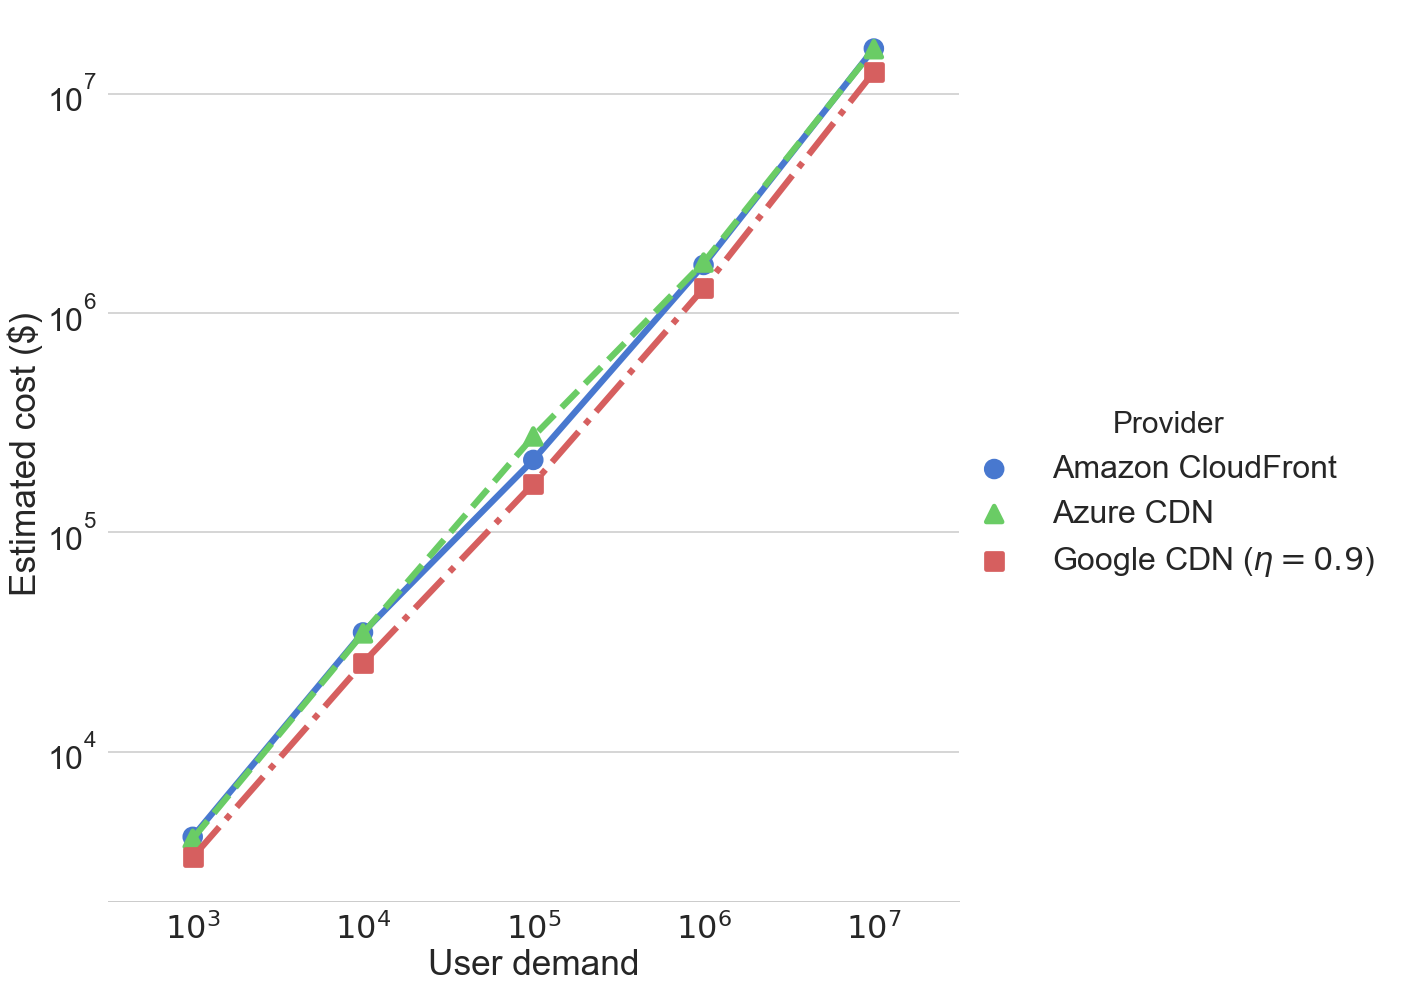

In [57]:
sns.set(style="whitegrid")
#fig, ax = plt.subplots()
#ax.set(xscale="log", yscale="log")
#sns.set_context("poster")
sns.set_context("poster", font_scale=2, rc={"lines.linewidth": 3.5})
g = sns.factorplot(x="samples", y="cost", hue="provider", data=total_cost_df.loc[total_cost_df['hit_rate']==0.9], kind="point", palette="muted", ci=95,
                  n_boot=1000, size=15, aspect=1, linestyles=["-", "--", "-."],markers=['o','^','s'])

g.despine(left=True)
g.set_ylabels("Estimated cost ($)")
g.set_xlabels("User demand")
g.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'] )
g.set(yscale="log")
g._legend.set_title('Provider')
#g._legend.set_label(['Amazon CloudFront', 'Azure CDN', 'Google Cloud CDN'])
#plt.show()

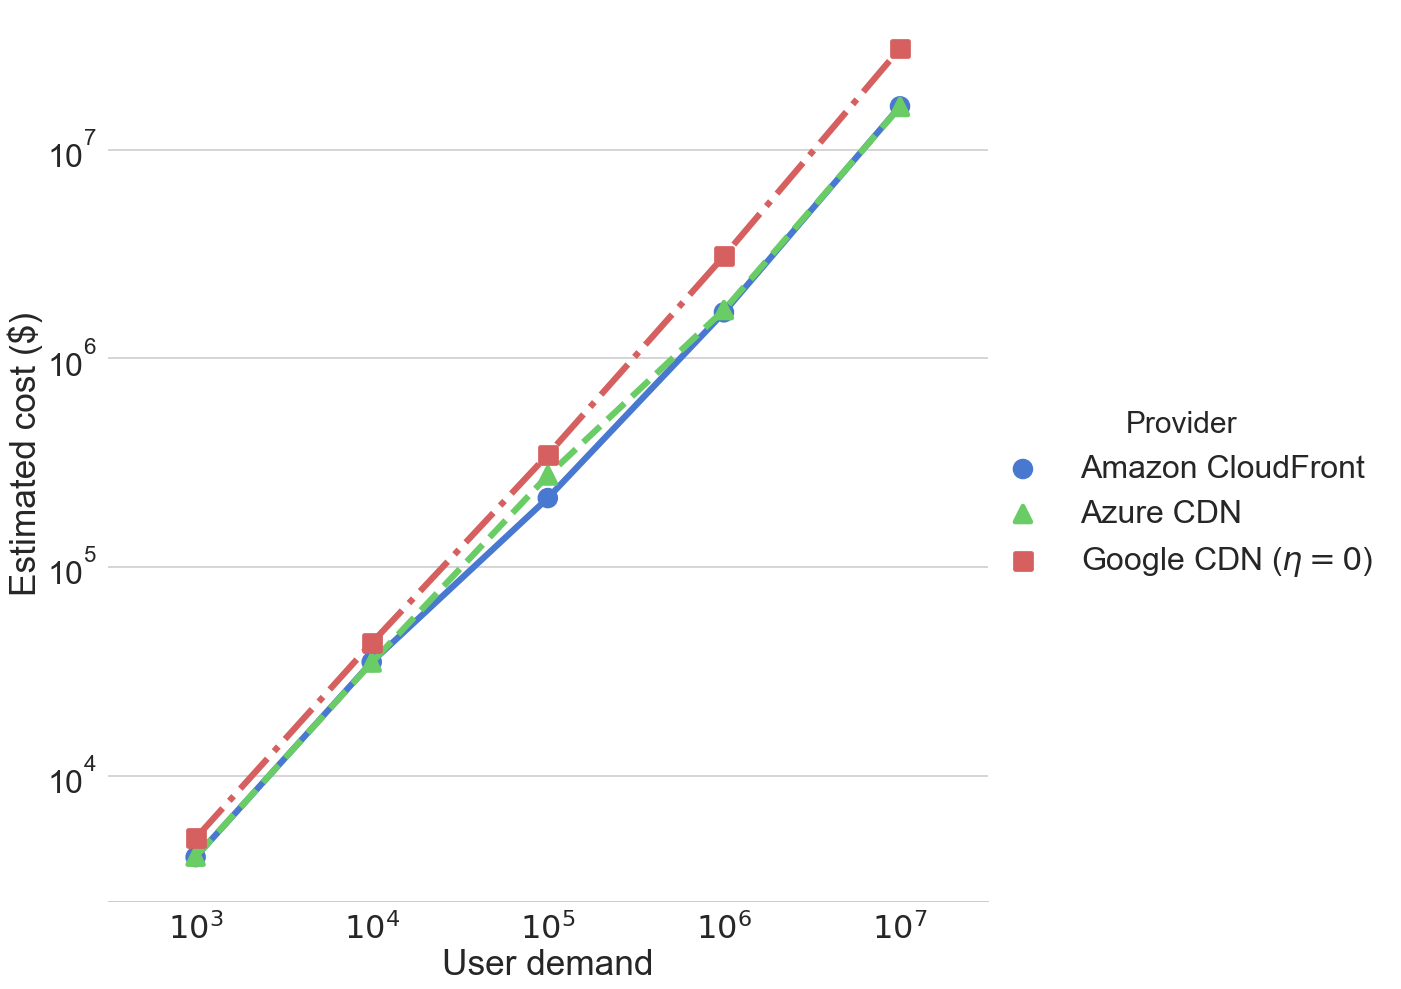

In [58]:
sns.set(style="whitegrid")
#fig, ax = plt.subplots()
#ax.set(xscale="log", yscale="log")
#sns.set_context("poster")
sns.set_context("poster", font_scale=2, rc={"lines.linewidth": 3.5})
g = sns.factorplot(x="samples", y="cost", hue="provider", data=total_cost_df.loc[total_cost_df['hit_rate']==0], kind="point", palette="muted", ci=95,
                  n_boot=1000, size=15, aspect=1, linestyles=["-", "--", "-."],markers=['o','^','s'])

g.despine(left=True)
g.set_ylabels("Estimated cost ($)")
g.set_xlabels("User demand")
g.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'] )
g.set(yscale="log")
g._legend.set_title('Provider')
#g._legend.set_label(['Amazon CloudFront', 'Azure CDN', 'Google Cloud CDN'])
#plt.show()

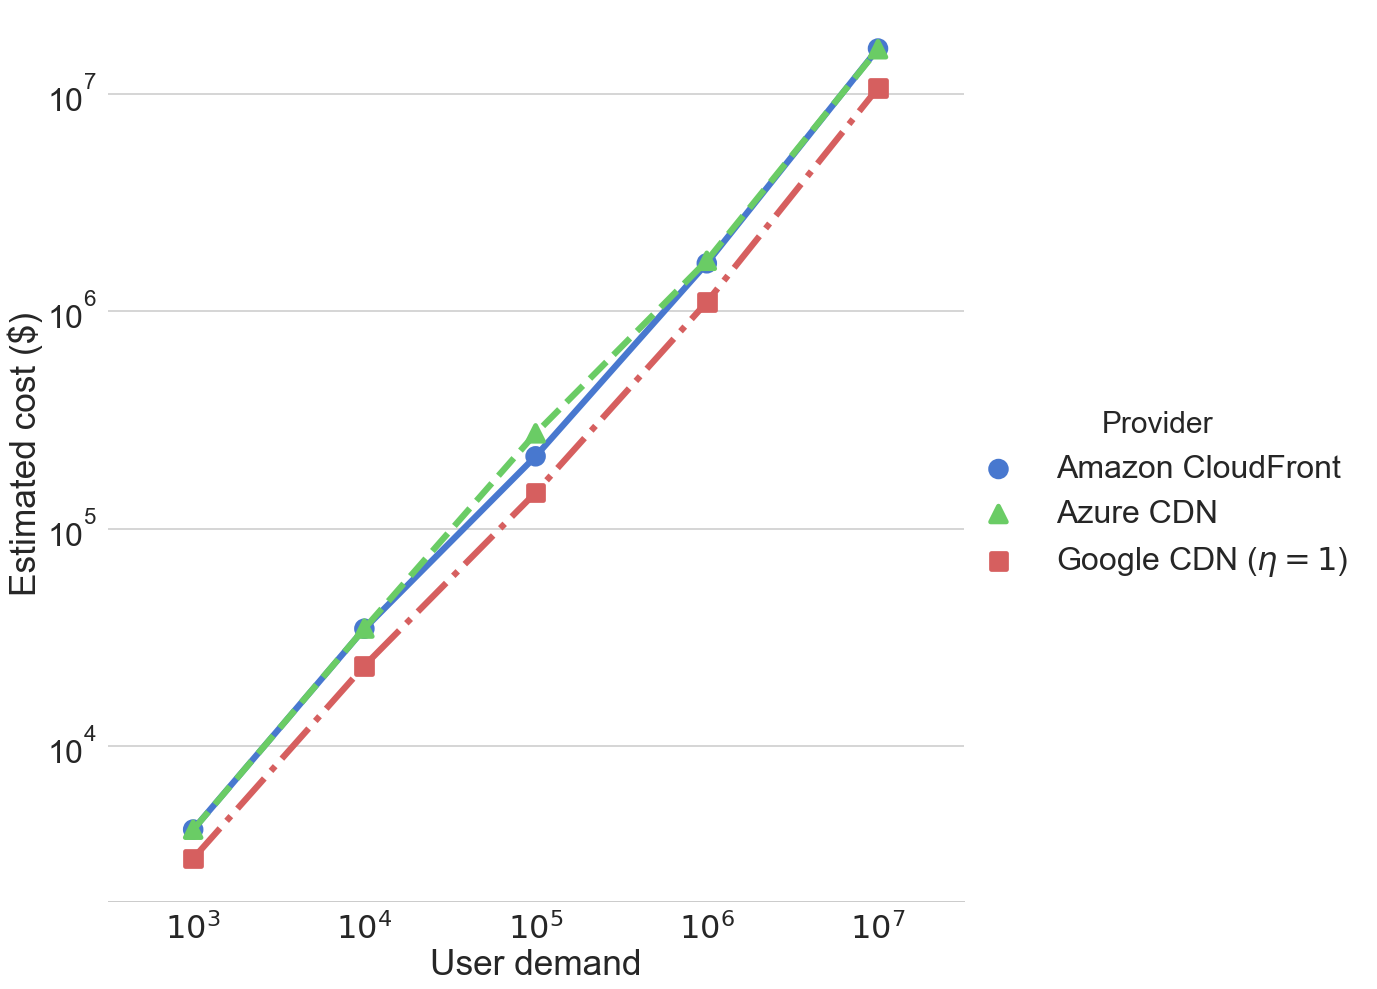

In [59]:
sns.set(style="whitegrid")
#fig, ax = plt.subplots()
#ax.set(xscale="log", yscale="log")
#sns.set_context("poster")
sns.set_context("poster", font_scale=2, rc={"lines.linewidth": 3.5})
g = sns.factorplot(x="samples", y="cost", hue="provider", data=total_cost_df.loc[total_cost_df['hit_rate']==1], kind="point", palette="muted", ci=95,
                  n_boot=1000, size=15, aspect=1, linestyles=["-", "--", "-."],markers=['o','^','s'])

g.despine(left=True)
g.set_ylabels("Estimated cost ($)")
g.set_xlabels("User demand")
g.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'] )
g.set(yscale="log")
g._legend.set_title('Provider')
#g._legend.set_label(['Amazon CloudFront', 'Azure CDN', 'Google Cloud CDN'])
#plt.show()

In [219]:
g._legend.get_texts()

'<a list of 3 Text objects>'